<a href="https://colab.research.google.com/github/mrdybax/exercicio-nzn/blob/main/nzn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1 - Entendendo o perfil demográfico e quantidade de acessos no período**
Nessa primeira seção, vamos visualizar de maneira simplificada a mensuração do volume de acessos, usuários e rejeição. Como estepe inicial, criamos uma função simples para tratar a conversão dos separadores decimais e de milhar ao padrão americano. Depois, aplicamos soluções únicas a cada tabela. Os comentários nos códigos explicam o caminho lógico tomado na manipulação.

In [ ]:
#importando funções e setando padrão de formatação das floats
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pd.options.display.float_format = '{:,.2f}'.format

#função para lidar com os números em string do excel
def converter_numero(valor):
  valor = valor.replace('.', '')
  valor = valor.replace(',','.')
  return float(valor)

#gerando o objeto excelfile
arquivo = pd.ExcelFile('/content/dados.xlsx')

## **A - Manipulando e vendo comportamento mensal das variáveis**
A primeira tabela a ser lida é a que contém as métricas diárias dos acessos. Como existem dados para todos os dias do mês fechado, é possível visualizar esses comportamentos em forma de série temporal. Fazemos isso aqui transformando as datas em index, após convertê-las ao tipo correto e limpar as linhas não formadas advindas do Excel. Printamos a descrição básica das variáveis como forma simples de buscar comportamentos excepcionais.



In [ ]:
#lendo a primeira tabela e já convertendo as strings em floats
audiencia = pd.read_excel(arquivo, sheet_name='Audiência', parse_dates=True, 
                          converters = {col : converter_numero for col in ('Visitantes', 'Pageviews', 'Visitas', 'Taxa de Rejeição')})

#convertendo datas, convertendo em index e dropando resíduos do excel
audiencia['Data'] = pd.to_datetime(audiencia['Data'], errors='coerce')
audiencia.dropna(inplace=True)
audiencia.set_index('Data', inplace=True)

#Métricas Básicas das variáveis
print(audiencia.describe())


       Visitantes  Pageviews    Visitas  Taxa de Rejeição
count       31.00      31.00      31.00             31.00
mean    65,580.65 318,354.84 172,000.00             76.90
std     11,589.58 102,548.38  37,237.08              5.83
min     46,000.00 155,000.00 106,000.00             66.92
25%     58,000.00 217,500.00 145,000.00             72.69
50%     66,000.00 325,000.00 165,000.00             76.34
75%     73,500.00 396,000.00 200,000.00             79.88
max     89,000.00 522,000.00 243,000.00             90.58


Feito isso, vamos agora visualizar cada variável em uma série temporal, compartilhando o eixo x. Plotamos cada uma em separado devido à diferença de escala na variação dos valores (uma forma diferente de tratar esse problema é normalizar a variável, caso desejemos analisar variâncias, mas nesse caso os valores absolutos também são importantes.

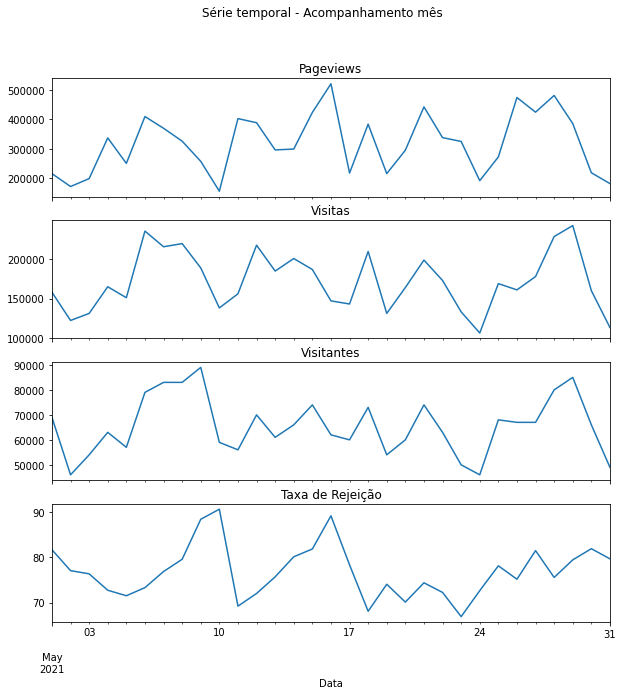

In [ ]:
#Criando subplots para cada variável como série temporal
fig, axes = plt.subplots(4, 1, sharex= True)
audiencia.plot(y=['Pageviews'], ax=axes[0], title = 'Pageviews', legend=None)
audiencia.plot(y=['Visitas'], ax=axes[1], title = 'Visitas', legend= None)
audiencia.plot(y=['Visitantes'], ax=axes[2], title = 'Visitantes', legend=None)
audiencia.plot(y=['Taxa de Rejeição'], ax=axes[3], title = 'Taxa de Rejeição', legend=None)
fig.suptitle('Série temporal - Acompanhamento mês')
fig.set_size_inches(10, 10)
plt.show()

Agora vamos visualizar a distribuição por dia da semana, para vermos se há algum efeito de aumento de visitas generalizado em função disso. A primeira visualização, em série temporal, nos ajuda a verificar se não há algum outlier.
Agora, agrupamos por média (já que o mês não tem exatamente o mesmo número de frequência para todos os dias da semana) e vemos a tendência de maiores acessos no final da semana útil, "esfriando" de domingo a terça-feira.

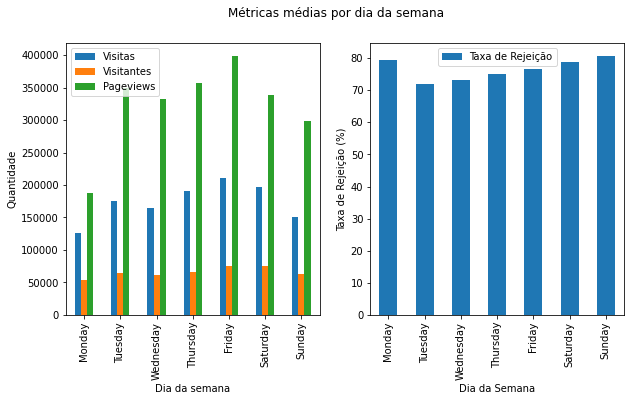

In [ ]:
#agrupando por dia da semana para capturar efeito sazonal
audiencia_dia_semana = audiencia.groupby(audiencia.index.day_name()).agg({'Visitas':'mean', 'Visitantes':'mean', 'Pageviews':'mean', 'Taxa de Rejeição':'mean'})
audiencia_dia_semana.reset_index(inplace=True)

audiencia_dia_semana['Data'] = pd.Categorical(audiencia_dia_semana['Data'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

#Criando subplots de barras
fig2, ax2 = plt.subplots(1, 2, sharex=True)
audiencia_dia_semana.sort_values('Data').plot.bar(x='Data', y=['Visitas', 'Visitantes', 'Pageviews'],
                                                  ylabel='Quantidade', xlabel = 'Dia da semana', ax=ax2[0])
audiencia_dia_semana.sort_values('Data').plot.bar(x='Data', y='Taxa de Rejeição', ax=ax2[1], xlabel  = 'Dia da Semana', ylabel = 'Taxa de Rejeição (%)')
fig2.suptitle('Métricas médias por dia da semana')
fig2.set_size_inches(10, 5)
plt.show()

#criando distribuição por dia da semana
audiencia['Dia da Semana'] = pd.Categorical(audiencia.index.day_name(), categories = 
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

audiencia.sort_values('Dia da Semana', inplace=True)

figx = go.Figure()

figx.add_trace(go.Box(x=audiencia['Dia da Semana'], y=audiencia['Visitas'], name='Visitas'))
figx.add_trace(go.Box(x=audiencia['Dia da Semana'], y=audiencia['Pageviews'], name='Pageviews'))
figx.update_layout(boxmode='group')
figx.update_yaxes(title = 'Quantidade Diária')
figx.update_layout(title='Distribuição de Visitas e Pageviews por dia da semana')
figx.show()

figx2 = go.Figure()
figx2.add_trace(go.Box(x=audiencia['Dia da Semana'], y=audiencia['Visitantes'], name='Visitantes'))
figx2.update_layout(title='Distribuição de usuários por dia da semana')
figx2.show()



## **B - Verificando os perfis de quem acessa o site**
Agora, vamos explorar os perfis categóricos de quem acessa o site. Para isso, vamos criar uma nova variável que categoriza os segmentos. Depois, conseguimos facilitar a exploração das ditribuições por meio de gráficos de barra simples.
Vemos também quais os 20 estados com mais números de acesso, por ordem de usuários.

In [ ]:
#lendo dados demográficos
demografia = pd.read_excel(arquivo, sheet_name='Demografia',
                           converters = {col: converter_numero for col in ('Usuários', 'Percentual')})

#criando grupos para as labels categóricas
conditions =[demografia['Segmento'].isin(['Solteiro', 'Casado']),
             demografia['Segmento'].isin(['Classe A/B', 'Classe C', 'Classe D/E']),
             demografia['Segmento'].isin(['35-59', '18-24', '25-34', '60+']),
             demografia['Segmento'].isin(['Mobile', 'Desktop', 'Tablet', 'Outros']),
             demografia['Segmento'].isin(['Não graduado', 'Graduado']),
             demografia['Segmento'].isin(['Homens', 'Mulheres'])]

escolhas = ['Estado Civil', 'Classe Social', 'Faixa Etária', 'Dispositivo', 'Escolaridade', 'Sexo']

demografia['Categoria'] = np.select(conditions, escolhas)

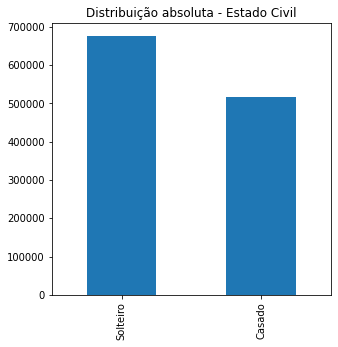

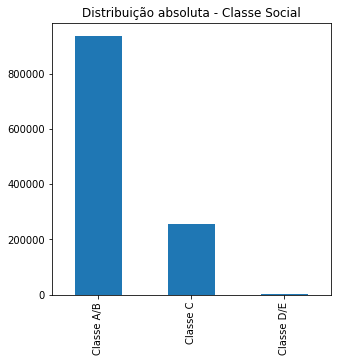

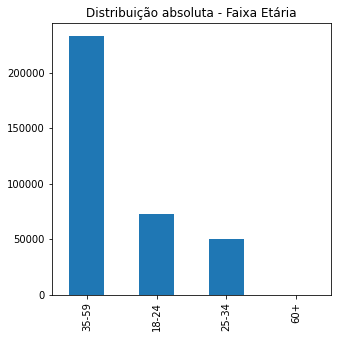

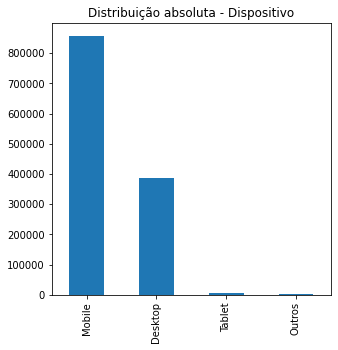

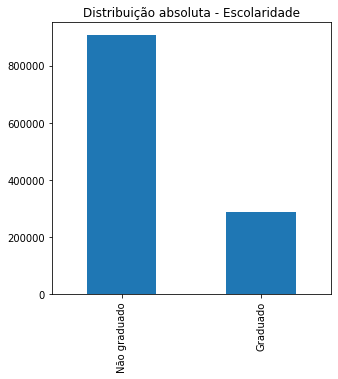

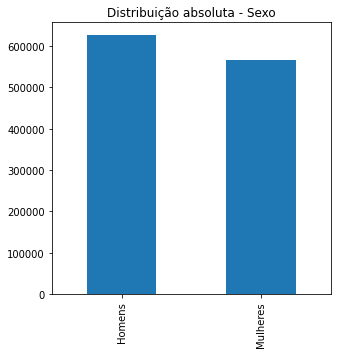

In [ ]:
#Plotando as categorias
for categoria in demografia['Categoria'].unique():
  df_cat = demografia.loc[demografia['Categoria'] == categoria]
  df_cat.plot(x='Segmento', y='Usuários', kind='bar', legend=None, figsize = (5, 5), title = f'Distribuição absoluta - {categoria}', xlabel="")
  plt.show()
  

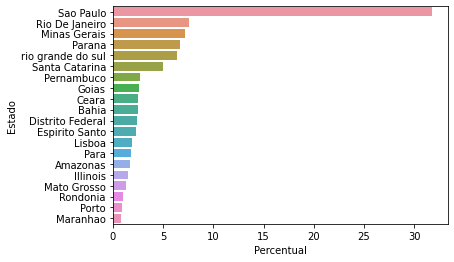

In [ ]:
regiao = pd.read_excel(arquivo, sheet_name = 'Região',
                       converters = {col:converter_numero for col in ('Usuários', 'Percentual')})

sns.barplot(y='Estado', x='Percentual', data=regiao.sort_values('Usuários', ascending=False).head(20))
plt.show()

#**2 - Verificando possíveis oportunidades nos diferentes segmentos**

Em primeiro lugar, criamos uma métrica simples de "score" que consiste na razão dentre usuários de determinado segmento pela métrica de afinidade. O resultado, que seria algo como "Usuários por ponto de afinidade", não tem interpretação direta, mas ajuda a nos apontar categorias com muitos usuários e poucos pontos de afinidade. Aqui, assumimos que esses são negócios potenciais (engajamento passa a ser foco). Não olhamos para a ótica de categorias com menos usuários e alto engajamento, pois assume-se que essas estão devidamente exploradas.

Como só há um nível de hierarquização nessa tabela ("Pai" > "Filho"), podemos olhar as categorias subsequentes excluindo as que são consideradas "pai" e vice-versa. Isso é importante pois o número de usuários das categorias-pai obviamente vai ser maior, influenciando a ordenação advinda do score. 
Dessa forma, podemos visualizar a relação de qualquer uma das óticas: de investir em algum segmento ou em alguma página específica.
No caso das categorias, adicionamos também uma métrica com a relação percentual de usuários do segmento-pai que acessam a página-filho em específico, para ter noção melhor do volume relativo de acessos.

In [ ]:
#Gerando a tabela de everybuyers
everybuyer = pd.read_excel(arquivo, sheet_name = 'Everybuyer',
                           converters = {col:converter_numero for col in ('Usuários', 'Percentual', 'Afinidade')})
everybuyer['score'] = everybuyer['Usuários'] / everybuyer['Afinidade']

#Gerando um df secundário de tabela com segmentos-pai
everybuyer_pais = everybuyer.loc[everybuyer['Pai'].isna()]
display(everybuyer_pais.sort_values('score', ascending = False).drop(columns=['Pai']))


,Segmento,Usuários,Percentual,Afinidade,score
16,Serviços Financeiros,"398,000.00",31.44,1.63,"244,171.78"
24,Comida e Bebida,"370,000.00",29.23,1.63,"226,993.87"
4,Carreira e Educação,"388,000.00",30.65,2.20,"176,363.64"
12,Esportes,"340,000.00",26.86,2.09,"162,679.43"
0,Moda e Beleza,"361,000.00",28.52,2.55,"141,568.63"
20,Veículos,"276,000.00",21.80,2.28,"121,052.63"
44,Telecomunicações,"205,000.00",16.19,1.78,"115,168.54"
28,Imobiliária,"256,000.00",20.22,2.29,"111,790.39"
48,Eletrônicos e Eletrodomésticos,"150,000.00",11.85,1.63,"92,024.54"
40,Casa e Construção,"220,000.00",17.38,2.40,"91,666.67"


O resultado dessa manipulação simples já nos mostra categorias com muitos usuários e métricas de afinidade baixas, potenciais alvos de atuação para melhoras futuras. Nesse sentido, apesar da métrica ser muito simples para um ranking "verdadeiro", podemos ter bons direcionamentos de para quais segmentos olharmos em busca de oportunidades.

In [ ]:
#Adicionando os parâmetros do segmento-pai aos segmentos-filho, usando um left join na tabela auto-relacionada
everybuyer_merged = pd.merge(everybuyer.loc[~everybuyer['Pai'].isna()], everybuyer_pais, left_on='Pai', right_on='Segmento', how='left', suffixes=('_filho', '_pai'))
everybuyer_merged = everybuyer_merged[['Segmento_filho', 'Usuários_filho', 'Percentual_filho', 'Afinidade_filho', 'Pai_filho', 'score_filho', 'Usuários_pai']]

#Criando uma coluna de percentual relativo de participações, considerando quantos usuários do segmento-pai acessam o filho
everybuyer_merged['Percentual_relativo'] = (everybuyer_merged['Usuários_filho'] / everybuyer_merged['Usuários_pai']) * 100

#Organizando por score
display(everybuyer_merged.sort_values('score_filho', ascending=False).drop(columns={'Usuários_pai'}).head(15))


,Segmento_filho,Usuários_filho,Percentual_filho,Afinidade_filho,Pai_filho,score_filho,Percentual_relativo
20,Top Chef,"229,000.00",18.09,1.27,Comida e Bebida,"180,314.96",61.89
11,Torcedores,"340,000.00",26.86,2.09,Esportes,"162,679.43",100.00
14,Planejador,"203,000.00",16.03,1.56,Serviços Financeiros,"130,128.21",51.01
15,Compacto,"247,000.00",19.51,2.30,Veículos,"107,391.30",89.49
12,Digital Exclusivo,"303,000.00",23.93,3.02,Serviços Financeiros,"100,331.13",76.13
3,EAD,"319,000.00",25.20,3.48,Carreira e Educação,"91,666.67",82.22
37,Open House,"132,000.00",10.43,1.63,Eletrônicos e Eletrodomésticos,"80,981.60",88.00
4,Vestibulandos,"263,000.00",20.77,3.27,Carreira e Educação,"80,428.13",67.78
5,Carreira,"232,000.00",18.33,2.99,Carreira e Educação,"77,591.97",59.79
0,Sofisticados,"256,000.00",20.22,3.42,Moda e Beleza,"74,853.80",70.91


Por fim, temos uma lista com os segmentos-filho, seus scores individuais e participação relativa no número de usuários do segmento-pai. A lista de oportunidades em potencial depende do tipo de ação a ser tomada e do projeto a ser feito. Caso deseje-se olhar por páginas em isolado, a escolha pode ser feita interagindo o percentual relativo com o score, para priorizar páginas mais acessadas do segmento. Caso deseje-se melhorar o segmento-pai, podemos usar o percentual relativo para atuar nas páginas com mais usuários e menos afinidade.

#**3 - Checando Interesses do Período**
A análise de interesses, em certa parte, aproxima-se muito da análise utilizada nos everybuyers. Há dois pontos principais de distinção: o aninhamento de categorias é maior (cada categoria pode ser especializada mais de uma única vez) e a afinidade parece não ter tanta importância quanto a quantidade absoluta de acessos distintos para definir o que seria um "hot topic". Claro, a interpretação do que é um "interesse" pode mudar de acordo com a abordagem, mas aqui assume-se que são aqueles temas com mais acessos. Assim, usamos um outro score simples, multiplicando usuários pela métrica de interesse, para ter algum nível de medição de "engajamento" dentro, agora com ponderação diretamente proporcional.

Como há uma rastreabilidade muito grande, a níveis muito específicos de categoria, vamos limitar a análise aos 10 níveis com mais usuários e, dentro desses, a distribuição em subníveis de primeiro grau (dependentes diretos) de cada.


In [ ]:
#criando um df de interesses
interesse = pd.read_excel(arquivo, sheet_name = 'Interesse',
                           converters = {col:converter_numero for col in ('Usuários', 'Percentual', 'Afinidade')})
interesse['score'] = interesse['Usuários'] * interesse['Afinidade']

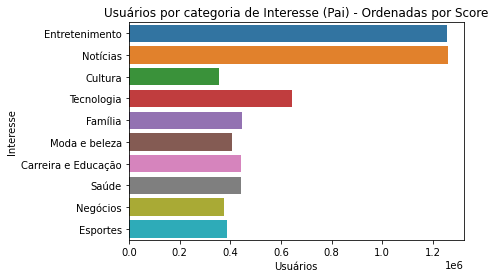

In [ ]:
#criando df com categorias-pai e ordenando
interesse_geral = interesse[interesse['Pai'].isnull()]
top_interesses_gerais = interesse_geral.sort_values('score', ascending=False).head(10)

#fazendo um gráfico com labels ordenadas por score, mas eixo x por usuários
graf = sns.barplot(x='Usuários', y='Interesse', data=top_interesses_gerais).set_title('Usuários por categoria de Interesse (Pai) - Ordenadas por Score')
plt.show()

Daqui, vemos as categorias de Entretenimento e Notícias com maior número de usuários. Um exemplo da visualização escolhida é que cultura aparece antes de tecnologia, que tem muito mais usuários, mas como o score de afinidade é maior, acaba sendo citada primeiro.

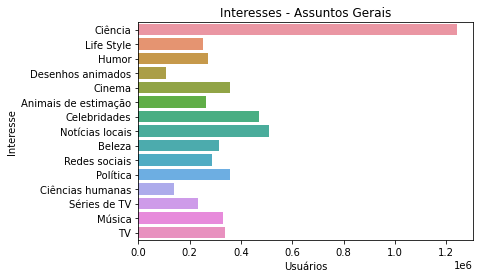

In [ ]:
#Plotando interesses com maior número de usuários, considerando hierarquias de primeiro grau das categorias-pai
interesse_nivel_1 = interesse.loc[interesse['Pai'].isin(top_interesses_gerais['Interesse'].unique())]

sns.barplot(x='Usuários', y='Interesse', data=interesse_nivel_1.head(15)).set_title('Interesses - Assuntos Gerais')
plt.show()

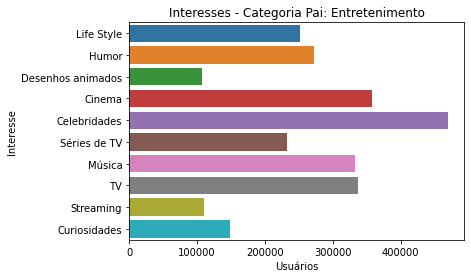

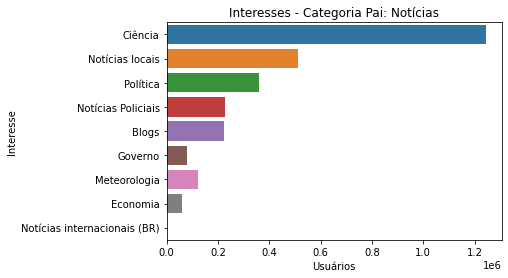

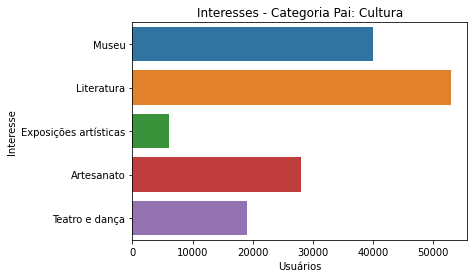

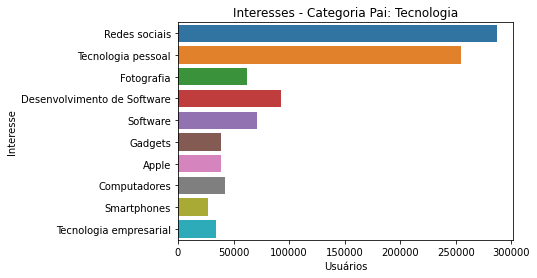

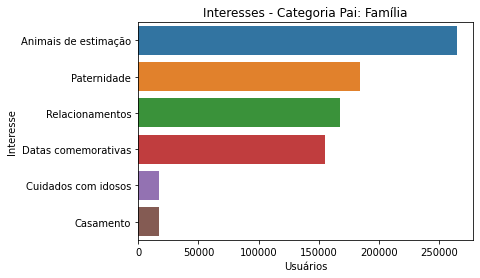

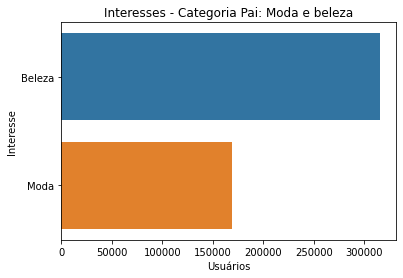

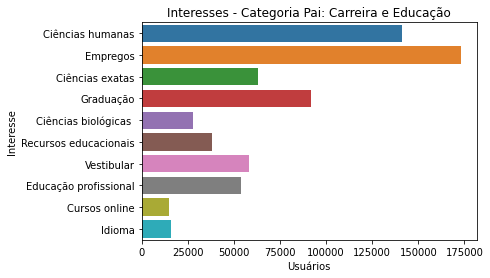

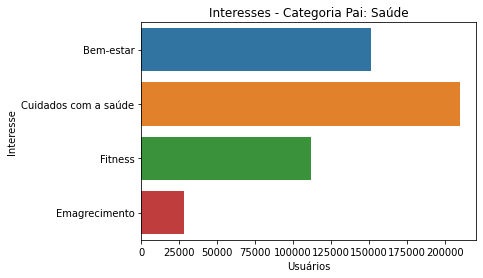

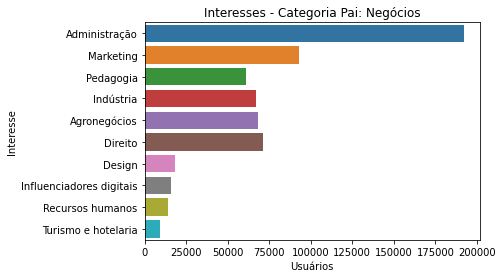

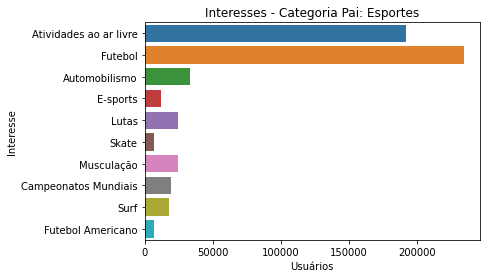

In [ ]:
#iterando pelas categorias-pai e extraindo os top assuntos de cada, limitando a 10
for categoria in top_interesses_gerais['Interesse'].unique():
  sns.barplot(x='Usuários', y='Interesse', data=interesse_nivel_1.loc[interesse_nivel_1['Pai'] == categoria].head(10)).set_title(f'Interesses - Categoria Pai: {categoria}')
  plt.show()